In [ ]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt

In [ ]:
#BWT for use in alignment
#Note: I incorporated elements from Lagmeads open resources
def rotations(t):
  tt=t*2
  return [ tt[i:i+len(t)] for i in range(len(t)) ] 

In [ ]:
def BWT(t):
  matrix=sorted(rotations(t))
  output=''
  for row in matrix:
    output=output+row[-1]
  return output

In [ ]:
###todo, fixup!
def BWT_inverse(t):
  temp=t
  output=""
  for i in range(1,len(t)+1):
    for j in range(1,len(t)+1):
      print(i,j)
      print(output)
      output.join(output[j]+sorted(output)[j])
  return output
    
  

In [ ]:
##Credit: Benjamin Langmead "FMIndex"
##next cells are from open source notebook
def suffixArray(s):
    ''' Given T return suffix array SA(T).  Uses "sorted"
        function for simplicity, which is probably very slow. '''
    satups = sorted([(s[i:], i) for i in range(len(s))])
    return list(map(lambda x: x[1], satups)) # extract, return just offsets

def bwtFromSa(t, sa=None):
    ''' Given T, returns BWT(T) by way of the suffix array. '''
    bw = []
    dollarRow = None
    if sa is None:
        sa = suffixArray(t)
    for si in sa:
        if si == 0:
            dollarRow = len(bw)
            bw.append('$')
        else:
            bw.append(t[si-1])
    return ''.join(bw), dollarRow # return string-ized version of list bw

In [ ]:
class FmCheckpoints(object):
    ''' Manages rank checkpoints and handles rank queries, which are
        O(1) time, with the checkpoints taking O(m) space, where m is
        length of text. '''
    
    def __init__(self, bw, cpIval=4):
        ''' Scan BWT, creating periodic checkpoints as we go '''
        self.cps = {}        # checkpoints
        self.cpIval = cpIval # spacing between checkpoints
        tally = {}           # tally so far
        # Create an entry in tally dictionary and checkpoint map for
        # each distinct character in text
        for c in bw:
            if c not in tally:
                tally[c] = 0
                self.cps[c] = []
        # Now build the checkpoints
        for i, c in enumerate(bw):
            tally[c] += 1 # up to *and including*
            if i % cpIval == 0:
                for c in tally.keys():
                    self.cps[c].append(tally[c])
    
    def rank(self, bw, c, row):
        ''' Return # c's there are in bw up to and including row '''
        if row < 0 or c not in self.cps:
            return 0
        i, nocc = row, 0
        # Always walk to left (up) when calculating rank
        while (i % self.cpIval) != 0:
            if bw[i] == c:
                nocc += 1
            i -= 1
        return self.cps[c][i // self.cpIval] + nocc

In [ ]:
st = 'teststring'
#     0123456789
cps = FmCheckpoints(st)

In [ ]:
# should get back list of integers, where elt i gives
# # times 't' appears up to and including offset i
[ cps.rank(st, 't', i) for i in range(10) ]

[1, 1, 1, 2, 2, 3, 3, 3, 3, 3]

In [ ]:
# likewise for 'g'
[ cps.rank(st, 'g', i) for i in range(10) ]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
class FmIndex():
    ''' O(m) size FM Index, where checkpoints and suffix array samples are
        spaced O(1) elements apart.  Queries like count() and range() are
        O(n) where n is the length of the query.  Finding all k
        occurrences of a length-n query string takes O(n + k) time.
        
        Note: The spacings in the suffix array sample and checkpoints can
        be chosen differently to achieve different bounds. '''
    
    @staticmethod
    def downsampleSuffixArray(sa, n=4):
        ''' Take only the suffix-array entries for every nth suffix.  Keep
            suffixes at offsets 0, n, 2n, etc with respect to the text.
            Return map from the rows to their suffix-array values. '''
        ssa = {}
        for i, suf in enumerate(sa):
            # We could use i % n instead of sa[i] % n, but we lose the
            # constant-time guarantee for resolutions
            if suf % n == 0:
                ssa[i] = suf
        return ssa
    
    def __init__(self, t, cpIval=4, ssaIval=4):
        if t[-1] != '$':
            t += '$' # add dollar if not there already
        # Get BWT string and offset of $ within it
        sa = suffixArray(t)
        self.bwt, self.dollarRow = bwtFromSa(t, sa)
        # Get downsampled suffix array, taking every 1 out of 'ssaIval'
        # elements w/r/t T
        self.ssa = self.downsampleSuffixArray(sa, ssaIval)
        self.slen = len(self.bwt)
        # Make rank checkpoints
        self.cps = FmCheckpoints(self.bwt, cpIval)
        # Calculate # occurrences of each character
        tots = dict()
        for c in self.bwt:
            tots[c] = tots.get(c, 0) + 1
        # Calculate concise representation of first column
        self.first = {}
        totc = 0
        for c, count in sorted(tots.items()):
            self.first[c] = totc
            totc += count
    
    def count(self, c):
        ''' Return number of occurrences of characters < c '''
        if c not in self.first:
            # (Unusual) case where c does not occur in text
            for cc in sorted(self.first.keys()):
                if c < cc: return self.first[cc]
            return self.first[cc]
        else:
            return self.first[c]
    
    def range(self, p):
        ''' Return range of BWM rows having p as a prefix '''
        l, r = 0, self.slen - 1 # closed (inclusive) interval
        for i in range(len(p)-1, -1, -1): # from right to left
            l = self.cps.rank(self.bwt, p[i], l-1) + self.count(p[i])
            r = self.cps.rank(self.bwt, p[i], r)   + self.count(p[i]) - 1
            if r < l:
                break
        return l, r+1
    
    def resolve(self, row):
        ''' Given BWM row, return its offset w/r/t T '''
        def stepLeft(row):
            ''' Step left according to character in given BWT row '''
            c = self.bwt[row]
            return self.cps.rank(self.bwt, c, row-1) + self.count(c)
        nsteps = 0
        while row not in self.ssa:
            row = stepLeft(row)
            nsteps += 1
        return self.ssa[row] + nsteps
    
    def hasSubstring(self, p):
        ''' Return true if and only if p is substring of indexed text '''
        l, r = self.range(p)
        return r > l
    
    def hasSuffix(self, p):
        ''' Return true if and only if p is suffix of indexed text '''
        l, r = self.range(p)
        off = self.resolve(l)
        return r > l and off + len(p) == self.slen-1
    
    def occurrences(self, p):
        ''' Return offsets for all occurrences of p, in no particular order '''
        l, r = self.range(p)
        return [ self.resolve(x) for x in range(l, r) ]

In [ ]:
fm = FmIndex('abaaba')

In [ ]:
fm.hasSubstring('aaba')

True

In [ ]:
fm.hasSubstring('aabb')

False

In [ ]:
fm.range('a')

(1, 5)

In [ ]:
fm.range('baaba')

(6, 7)

In [ ]:
p, t = "CAT", "TTGTGTGCATGTTGTTTCATCATTTAGAGATACATTGCGCTGCATCATGGTCA"
#              01234567890123456789012345678901234567890123456789012
# Occurrences:        *         *  *           *         *  *
fm = FmIndex(t)
matches = sorted(fm.occurrences(p))
matches == [7, 17, 20, 32, 42, 45]

####end credit

True

In [ ]:
#regular DP global alignment for basis of comparison in simulations:
def S(x,y):
  if x==y:
    return 5
  if x == '-' or y == '-': 
    return -2
  else:
    return -5

def DPalignment(x,y,S):
  M=np.zeros((len(x),len(y)))
  for i in range(len(x)):
    for j in range(len(y)):
      M[i,j]=max(
          M[i-1,j-1]+S(x[i],y[j]),
          M[i,j-1]+S(x[i],"-"),
          M[i-1,j]+S("-",y[j])
      )
  return M[len(x)-1,len(y)-1]



In [ ]:
DPalignment('TACGTCAGC', 'TATGTCATGC',S)

34.0

In [ ]:
#functions for use in alignmnent in protein space
import numpy as np

def convert(nucleotide_sequence):
    #dictionary to convert nucleotide
    mapping={
    "GCT": "A",
    "GCC": "A",
    "GCA": "A",
    "GCG": "A",
    "CGT": "R",
    "CGC" : "R",
    "CGA" : "R",
    "CGG": "R",
    "AGA": "R",
    "AGG": "R",
    "AAT": "N",
    "AAC": "N",
    "GAT": "D",
    "GAC": "D",
    "AAT": "B",
    "AAC": "B",
    "GAT": "B",
    "GAC": "B",
    "TGT": "C",
    "TGC": "C",
    "CAA":"Q",
    "CAG": "Q",
    "GAA": "E",
    "GAG": "E",
    "CAA": "Z", 
    "CAG": "Z",
    "GAA": "Z", 
    "GAG": "Z",
    "GGT": "G", 
    "GGC": "G",
    "GGA": "G",
    "GGG": "G",
    "CAT": "H",
    "CAC": "H",
    "ATG": "M",
    "ATT": "I",
    "ATC": "I", 
    "ATA": "I",
    "CTT": "L", 
    "CTC": "L", 
    "CTA": "L", 
    "CTG": "L",
     "TTA": "L",
     "TTG" : "L",
     "AAA": "K",
    "AAG": "K",
    "TTT": "F",
    "TTC": "F",
    "CCT": "P", 
    "CCC": "P", 
    "CCA": "P", 
    "CCG": "P", 
    "TCT": "S", 
    "TCC": "S", 
    "TCA": "S", 
    "TCG": "S", 
    "AGT": "S", 
    "AGC": "S",
    "ACT": "T", 
    "ACC": "T", 
    "ACA": "T", 
    "ACG" : "T",
    "TGG": "W",
    "TAT": "Y", 
    "TAC": "Y",
    "GTT": "V", 
    "GTC": "V", 
    "GTA": "V", 
    "GTG": "V",
    "TAA": "U", 
    "TGA": "U", 
    "TAG": "U",#stop codons


    }
    protein=""
    counter=0
    while counter<=len(nucleotide_sequence)-3:
      protein=protein+mapping[nucleotide_sequence[counter:counter+3]]
      counter=counter+3;
    return protein

In [ ]:
convert("GCTCGTAGAAGGGAT")

'ARRRB'

In [ ]:
seq="GCTCGTAGAAGGGAT"

In [ ]:
def translate_reads(nucleotide_sequence):
  orfs=[]
  #given read, check 6 ORF and create protein sequence for each
  for i in range(3):
    protein=convert(nucleotide_sequence[i:])
    orfs.append(protein)
  #complement direction  
  reversed=nucleotide_sequence[::-1]
  for i in range(3):
    protein=convert(reversed[i:])
    orfs.append(protein)
  return(orfs)

In [ ]:
translate_reads(seq)

['ARRRB', 'LVZG', 'SUKG', 'UGRCS', 'RZBA', 'GKML']

In [ ]:
#alignment of reads in protein space, if given reference protein
def align(protein_ref, nucleotide_sequence):
  reads=translate_reads(nucleotide_sequence)
  
  best_value=0
  for read in reads:
    j=0
    matches=0
    i=0
    while i <len(read) and j<len(protein_ref):
      if read[i]==protein_ref[j]:
         matches=matches+1
         j=j+1
         i=i+1
      else:
        j=j+1
    if matches>=best_value:
      best_value=matches
      best_read=read
  return(best_read,best_value)

      
    


    

In [ ]:
align('LRZBA',seq)

('RZBA', 4)

In [ ]:
#improved alignment in protein space if given protein reference
def align2(protein_ref, nucleotide_sequence):
  reads=translate_reads(nucleotide_sequence)
  
  best_value=0
  for k in range(len(reads)):
    read=reads[k]
    j=0
    i=0
    for i in range(len(read)):
      for j in range(len(protein_ref)):
        matches=0
        if read[:i]==protein_ref[j:j+i]:
          matches=1+matches+i
        if matches>=best_value:
          best_value=matches
          best_read=read
          #start of match in protein space
          start=j
          number=k
  return(number,start,best_read,best_value)


In [ ]:
align2('LRZBA',seq)

(4, 1, 'RZBA', 4)

In [ ]:
def align3(nuc_ref,protein_ref,nucleotide_sequence):
  number,start,best_read,best_value=align2(protein_ref,nucleotide_sequence)
  if best_value != len(best_read):
    #look up read loc
    if number<3:
      loc=number+best_value*3
      read=nucleotide_sequence[loc::]
    elif number>2:
      reversed=nucleotide_sequence[::-1]
      loc=(number-3)+best_value*3
      read=reversed[loc::]
    i=0
    j=0
    while i <len(read) and j<len(protein_ref):
      if read[i]==protein_ref[j]:
         matches=matches+1
         j=j+1
         i=i+1
    return matches
  elif best_value == len(best_read):
    return "fully mapped"
    


In [ ]:
align3("GCTCGTGCTCGTAGAAGGGAGAAGGGAT",'LRZBA',seq)

'fully mapped'

In [ ]:
#test FM index in protein space only
#for exact match of full read
def align_BWT_protein(nuc_read,nucleotide_sequence):
  #create 6 ORF of read
  reads=translate_reads(nuc_read)

  #convert ref sequence to protein space
  #create FM index
  ref_protein=FmIndex(convert(nucleotide_sequence))
  number_matches=0
  matched=[]
  for read in reads:
    matches = sorted(ref_protein.occurrences(read))
    #track all reads that matched
    if ref_protein.hasSubstring(read):
      matched.append(read)

    #choose read as best based on existence+number of matches
    #best match location is last
    if len(matches)!=0 and len(matches)>number_matches:
      number_matches=matches
      best_read=read
      best_match=matches[-1]
  read_number=reads.index(best_read)

  return best_read,read_number,best_match


In [ ]:
p,t="ATGCGTAGTAA","GCTCGTGCATGCGTAGTAATCGTAGAAGGGAGAAGGGAT"
fm = FmIndex(t)
matches = sorted(fm.occurrences(p))
print(matches)

[8]


In [ ]:
p1,t1=convert(p),convert(t)
fm = FmIndex(t1)
matches = sorted(fm.occurrences(p1))
print(matches)
print(p1,t1)

[]
MRS ARACVVIVZGRRB


In [ ]:
align_BWT_protein(p,t)

('CVV', 1, 3)

In [ ]:
#refine translate and convert to store information beyond codons:
def convert2(nucleotide_sequence):
    #dictionary to convert nucleotide
    mapping={
    "GCT": "A",
    "GCC": "A",
    "GCA": "A",
    "GCG": "A",
    "CGT": "R",
    "CGC" : "R",
    "CGA" : "R",
    "CGG": "R",
    "AGA": "R",
    "AGG": "R",
    "AAT": "N",
    "AAC": "N",
    "GAT": "D",
    "GAC": "D",
    "AAT": "B",
    "AAC": "B",
    "GAT": "B",
    "GAC": "B",
    "TGT": "C",
    "TGC": "C",
    "CAA":"Q",
    "CAG": "Q",
    "GAA": "E",
    "GAG": "E",
    "CAA": "Z", 
    "CAG": "Z",
    "GAA": "Z", 
    "GAG": "Z",
    "GGT": "G", 
    "GGC": "G",
    "GGA": "G",
    "GGG": "G",
    "CAT": "H",
    "CAC": "H",
    "ATG": "M",
    "ATT": "I",
    "ATC": "I", 
    "ATA": "I",
    "CTT": "L", 
    "CTC": "L", 
    "CTA": "L", 
    "CTG": "L",
     "TTA": "L",
     "TTG" : "L",
     "AAA": "K",
    "AAG": "K",
    "TTT": "F",
    "TTC": "F",
    "CCT": "P", 
    "CCC": "P", 
    "CCA": "P", 
    "CCG": "P", 
    "TCT": "S", 
    "TCC": "S", 
    "TCA": "S", 
    "TCG": "S", 
    "AGT": "S", 
    "AGC": "S",
    "ACT": "T", 
    "ACC": "T", 
    "ACA": "T", 
    "ACG" : "T",
    "TGG": "W",
    "TAT": "Y", 
    "TAC": "Y",
    "GTT": "V", 
    "GTC": "V", 
    "GTA": "V", 
    "GTG": "V",
    "TAA": "U", 
    "TGA": "U", 
    "TAG": "U",#stop codons


    }
    protein=""
    counter=0
    while counter<=len(nucleotide_sequence)-3:
      protein=protein+mapping[nucleotide_sequence[counter:counter+3]]
      counter=counter+3;
    return protein,nucleotide_sequence[counter::]

In [ ]:
convert2("GCTCGTAGAAGGGG")

('ARRR', 'GG')

In [ ]:
def translate_reads2(nucleotide_sequence):
  orfs=[]
  nucs=[]
  #given read, check 6 ORF and create protein sequence for each
  for i in range(3):
    protein,extra=convert2(nucleotide_sequence[i:])
    orfs.append(protein)
    nucs.append(extra)
  #complement direction  
  reversed=nucleotide_sequence[::-1]
  for i in range(3):
    protein=convert2(reversed[i:])
    orfs.append(protein)
    nucs.append(extra)
  return(orfs,nucs)

In [ ]:
translate_reads2(seq)

(['ARRRB', 'LVZG', 'SUKG', 'UGRCS', 'RZBA', 'GKML'],
 ['', 'AT', 'T', 'T', 'T', 'T'])

In [ ]:
#test FM index in protein space and nucleotide space
#start with exact alignment in protein space, then align in nucleotide space
import time
def align_BWT_protein_nuc(nuc_read,nucleotide_sequence):
  start_time=time.time()
  #create 6 ORF of read
  reads,extras=translate_reads2(nuc_read)
  
  #convert ref sequence to protein space
  #create FM index
  ref_protein=FmIndex(convert(nucleotide_sequence))
  number_matches=0
  matched=[]
  for read in reads:
    matches = sorted(ref_protein.occurrences(read))
    #track all reads that matched
    if ref_protein.hasSubstring(read):
      matched.append(read)

    #choose read as best based on existence+number of matches
    #best match location is last
    if len(matches)!=0 and len(matches)>number_matches:
      number_matches=len(matches)
      best_read=read
      best_match=matches[-1]
      read_number=reads.index(best_read)

      #if the best matched read has leftover nucleotide information, use to map further (should this be separate scoring?)
      if extras[read_number]!="":
        newread=extras[read_number]
        newref=nucleotide_sequence[:best_match*3]
        i=0
        j=0
        while i <len(newread) and j<len(newref):
            if newread[i]==newref[j]:
              number_matches=number_matches+1
              j=j+1
              i=i+1
            else:
              i=i+1
      
  end_time=time.time()
  return best_read,read_number,best_match, end_time-start_time



    


In [ ]:
align_BWT_protein_nuc(p,t)

('CVV', 1, 3, 0.0003147125244140625)

In [ ]:
#simulate read from reference protein for various lengths and various length reads
def simulate_read(read_length,ref_length):
  ref=''
  for i in range(ref_length):
    toss=rand.random()
    if toss<.25:
      ref=ref+"A"
    if .25<=toss and toss<.5:
      ref=ref+"C"
    if .5<=toss and toss<.75:
      ref=ref+"G"
    else:
      ref=ref+"T"
  
  guess=rand.randint(0, ref_length-read_length)
  read=ref[guess::]
  return read, ref, guess



In [ ]:
simulate_read(20,100)

('TTTCTTCTTATTTGCTGTATTGATATTATCTTTGGCTTCTTGTCTCTTGGATTTATGGTGCTCTCTGATATATGGCTCTCTTGCTCTCTTGCTCTCTATCTTCTGCTCTATGGCTATCTCTATGATCTATTATATTTG',
 'GCTTATCTTTGTTTCTTCTTATTTGCTGTATTGATATTATCTTTGGCTTCTTGTCTCTTGGATTTATGGTGCTCTCTGATATATGGCTCTCTTGCTCTCTTGCTCTCTATCTTCTGCTCTATGGCTATCTCTATGATCTATTATATTTG',
 11)

In [ ]:
"TCTGCTTATCTTATATGGTTTGATGATATCTTGCTCTATTGTTATGGTGATCTTATCTATGATCTTGTCTGCTCTGATTCTTCTGTGGGTGATATCTCTGTATATCTCTTGATGATATTGGATATTATTCTCTCTTGATATCTGATTT".index('GTCTGCTCTGATTCTTCTGTGGGTGATATCTCTGTATATCTCTTGATGATATTGGATATTATTCTCTCTTGATATCTGATTT')

66

In [ ]:
#lightly modified output for align function for testing
#test FM index in protein space and nucleotide space
#only for exact match of full read
import time
def align_test(nuc_read,nucleotide_sequence):
  start_time=time.time()
  #create 6 ORF of read
  reads,extras=translate_reads2(nuc_read)
  
  #convert ref sequence to protein space
  #create FM index
  ref_protein=FmIndex(convert(nucleotide_sequence))
  number_matches=0
  matched=[]
  for read in reads:
    matches = sorted(ref_protein.occurrences(read))
    #track all reads that matched
    if ref_protein.hasSubstring(read):
      matched.append(read)

    #choose read as best based on existence+number of matches
    #best match location is last
    if len(matches)!=0 and len(matches)>number_matches:
      number_matches=len(matches)
      best_read=read
      best_match=matches[-1]
      read_number=reads.index(best_read)

      #if the best matched read has leftover nucleotide information, use to map further (should this be separate scoring?)
      if extras[read_number]!="":
        newread=extras[read_number]
        newref=nucleotide_sequence[:best_match*3]
        i=0
        j=0
        while i <len(newread) and j<len(newref):
            if newread[i]==newref[j]:
              number_matches=number_matches+1
              j=j+1
              i=i+1
            else:
              i=i+1
      
  end_time=time.time()
  return best_read,number_matches,best_match, end_time-start_time



    


In [ ]:
#test for comparison of speed with DP global alignment
def DPtest(read_length,ref_length,number_of_reads):
  start_overall=time.time()
  correct=0
  for i in range(number_of_reads):
    read,ref,location=simulate_read(read_length,ref_length)
    score=DPalignment(read,ref,S)
    if score>0:
      correct=correct+1
  accuracy=correct/number_of_reads
  end_overall=time.time()
  overalltime=end_overall-start_overall
  return accuracy, overalltime

In [ ]:
accuracy, overalltime=DPtest(20,1000,100)

In [ ]:
print("accuracy:%f" %accuracy)
print("overalltime:%f" %overalltime)

In [ ]:
#test align function on randomly generated reads
#should give measure of speed of alignment
def test(read_length,ref_length,number_of_reads):
  start_overall=time.time()
  correct=0
  times_correct=[]
  for i in range(number_of_reads):
    read,ref,location=simulate_read(read_length,ref_length)
    best_read,number_matches,best_match, read_time=align_test(read,ref)
    if (len(best_read)+2)>=read_length:
      correct=correct+1
      times_correct.append(read_time)
  accuracy=correct/number_of_reads
  avg_time_correct=sum(times_correct)/len(times_correct)
  end_overall=time.time()
  overalltime=end_overall-start_overall
  return accuracy,avg_time_correct, overalltime



In [ ]:
accuracy,avg_time_correct, overalltime=test(20,1000,10000)

In [ ]:
print("accuracy:%f" %accuracy)
print("avg_time_correct:%f" %avg_time_correct)
print("overalltime:%f" %overalltime)

In [ ]:
#plot alignment function on randomly generated reads for varying number of reads:
def plot_times(start,end,step):
    times=[]
    X=[]
    for i in range(start,end,step):
      X.append(i)
      accuracy,avg_time_correct, overalltime=test(20,1000,i)
      times.append(overalltime)
    fig,ax=plt.subplots()
    ax.plot(X,times,label='toy model')
    ax.set_xlabel('number of reads')  # Add an x-label to the axes.
    ax.set_ylabel('overall time')  # Add a y-label to the axes.
    ax.legend()


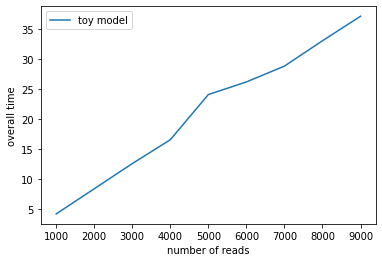

In [ ]:
plot_times(1000,10000,1000)

In [ ]:
#test for comparison of speed of toy model and DP global alignment
def S(x,y):
  if x==y:
    return 5
  if x == '-' or y == '-': 
    return -2
  else:
    return -5

def DPcompare(x,y,S):
  start_overall=time.time()
  M=np.zeros((len(x),len(y)))
  for i in range(len(x)):
    for j in range(len(y)):
      M[i,j]=max(
          M[i-1,j-1]+S(x[i],y[j]),
          M[i,j-1]+S(x[i],"-"),
          M[i-1,j]+S("-",y[j])
      )
  end_overall=time.time()
  overalltime=end_overall-start_overall
  return M[len(x)-1,len(y)-1],overalltime

def modelcompare(read,ref):
  start_overall=time.time()
  correct=0
  best_read,number_matches,best_match, read_time=align_test(read,ref)
  if (len(best_read)+2)>=len(read):
    correct=correct+1
  end_overall=time.time()
  overalltime=end_overall-start_overall
  return overalltime

def compare_plot(read_length,ref_length,number_of_reads):
  modeltimes=[]
  DPtimes=[]
  X=[]
  for i in range(1,number_of_reads,1000):
    read,ref,location=simulate_read(read_length,ref_length)
    X.append(i)
    model=modelcompare(read,ref)
    modeltimes.append(model)
    M,dptime=DPcompare(read,ref,S)
    DPtimes.append(dptime)
  fig,ax=plt.subplots()
  ax.plot(X,modeltimes,label='toy model')
  ax.plot(X,DPtimes,label='DP global alignment')
  ax.set_xlabel('number of reads')  # Add an x-label to the axes.
  ax.set_ylabel('overall time')  # Add a y-label to the axes.
  ax.legend()

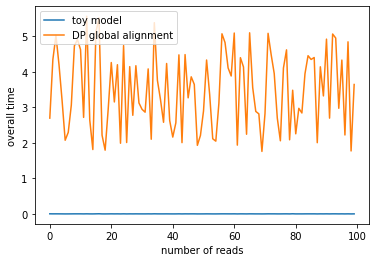

In [ ]:
#average time per read, baseline test 
compare_plot(20,1000,100)

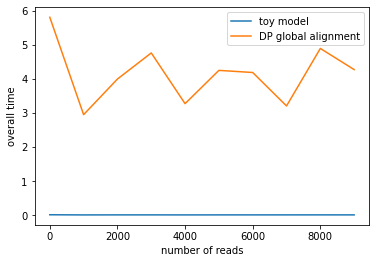

In [ ]:
compare_plot(20,1000,10000)

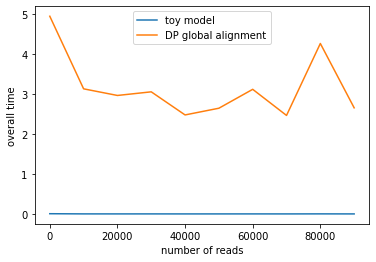

In [ ]:
compare_plot(20,1000,100000)

In [ ]:
def compare_plot2(read_length):
  modeltimes=[]
  DPtimes=[]
  X=[]
  for i in range(100,10000,1000):
    read,ref,location=simulate_read(read_length,i)
    X.append(i)
    model=modelcompare(read,ref)
    modeltimes.append(model)
    M,dptime=DPcompare(read,ref,S)
    DPtimes.append(dptime)
  fig,ax=plt.subplots()
  ax.plot(X,modeltimes,label='toy model')
  ax.plot(X,DPtimes,label='DP global alignment')
  ax.set_xlabel('reference length')  # Add an x-label to the axes.
  ax.set_ylabel('overall time')  # Add a y-label to the axes.
  ax.legend()

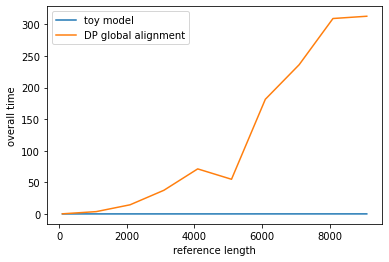

In [ ]:
#runtime vs. reference length
compare_plot2(50)

In [ ]:
#test for comparison of speed of toy model and DP global alignment
def S(x,y):
  if x==y:
    return 5
  if x == '-' or y == '-': 
    return -2
  else:
    return -5

def DPcompare(x,y,S):
  M=np.zeros((len(x),len(y)))
  for i in range(len(x)):
    for j in range(len(y)):
      M[i,j]=max(
          M[i-1,j-1]+S(x[i],y[j]),
          M[i,j-1]+S(x[i],"-"),
          M[i-1,j]+S("-",y[j])
      )
  return M[len(x)-1,len(y)-1]

def modelcompare(read,ref):
  correct=0
  best_read,number_matches,best_match, read_time=align_test(read,ref)
  if (len(best_read)+2)>=len(read):
    correct=correct+1
  return correct

def compare_plot3(read_length,ref_length,number_of_reads):
  modeltimes=[]
  DPtimes=[]
  X=[]
  for i in range(1,number_of_reads,20):
    X.append(i)
    reads=[]
    refs=[]
    for j in range(i):
      read,ref,location=simulate_read(read_length,ref_length)
      reads.append(read)
      refs.append(ref)

    model_start=time.time()
    for j in range(i):
      model=modelcompare(reads[j],refs[j])
    model_end=time.time()
    modeltimes.append(model_end-model_start)

    DPstart=time.time()
    for j in range(i):
      DP=DPcompare(reads[j],refs[j],S)
    DP_end=time.time()
    DPtimes.append(DP_end-DPstart)
  fig,ax=plt.subplots()
  ax.plot(X,modeltimes,label='toy model')
  ax.plot(X,DPtimes,label='DP global alignment')
  ax.set_xlabel('number of reads')  # Add an x-label to the axes.
  ax.set_ylabel('overall time')  # Add a y-label to the axes.
  ax.legend()

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []


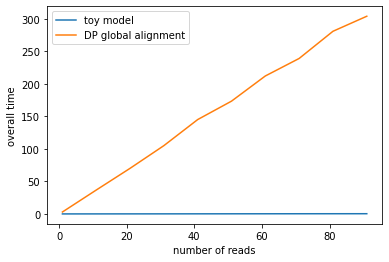

In [ ]:
#runtime vs number reads
compare_plot3(20,1000,100)

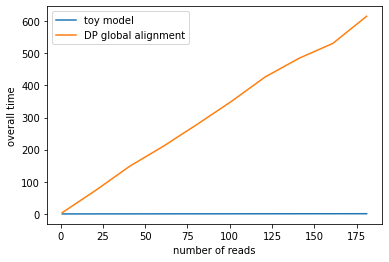

In [ ]:
compare_plot3(20,1000,200)